# 1. Extraire les probabilités de défaut implicites


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import binom, norm, skew, kurtosis, t, beta
from scipy.optimize import minimize

In [2]:
def pd_from_cds(spread_bp, maturity, recovery=0.40):
    """ 
    Fonction pour extraire les probabilité de défaut implicite
    """
    # Conversion bp -> décimal (1bp = 0.0001)
    spread = spread_bp / 10000  
    lambda_ = spread / (1 - recovery)
    pd = 1 - np.exp(-lambda_ * maturity)
    return pd

In [3]:
# Pour BNP
pd_bnp_4y = pd_from_cds(100, 4)
pd_bnp_5y = pd_from_cds(120, 5)

# Pour SG
pd_sg_4y = pd_from_cds(120, 4)
pd_sg_5y = pd_from_cds(150, 5)

print("PD BNP 4 ans :", pd_bnp_4y)
print("PD BNP 5 ans :", pd_bnp_5y)
print("PD SG 4 ans :", pd_sg_4y)
print("PD SG 5 ans :", pd_sg_5y)


PD BNP 4 ans : 0.06449301496838222
PD BNP 5 ans : 0.09516258196404048
PD SG 4 ans : 0.07688365361336424
PD SG 5 ans : 0.11750309741540454


# 2. Caractériser les distributions des taux de recouvrement de chacune des deux créances

In [4]:
# Pour carctériser les distributions des taux de recouvrement, on suppose que les recouvrement 
# suivent une loi Beta
# On déduit les paramètres à partir de la moyenne et de la volatilité

def beta_params(mean, vol):
    """  
    Fonction qui retourne les paramètres de la loi Beta à partir de la moyenne et de la volatilité
    """
    a_chapeau = (mean**2 * (1 - mean))/(vol**2) - mean
    b_chapeau = (mean**2 * (1 - mean)**2)/(mean * vol**2) - (1- mean)

    return a_chapeau, b_chapeau


In [5]:
# Pour BNP (moyenne 60 %, vol 15 %)
mean_bnp = 0.60
vol_bnp = 0.15
a_chapeau_bnp, b_chapeau_bnp = beta_params(mean_bnp, vol_bnp)

# Pour SG (moyenne 30 %, vol 25 %)
mean_sg = 0.30
vol_sg = 0.25
a_chapeau_sg, b_chapeau_sg= beta_params(mean_sg, vol_sg)

print("BNP Beta parameters: alpha =", a_chapeau_bnp, "beta =", b_chapeau_bnp)
print("SG Beta parameters: alpha =", a_chapeau_sg, "beta =", b_chapeau_sg)

BNP Beta parameters: alpha = 5.8 beta = 3.8666666666666676
SG Beta parameters: alpha = 0.708 beta = 1.652


## Interpétation :
  - ## Pour BNP : a > b donc asymétrie à droite
  - ## Pur SG : a < b  donc asymétrie à gauche ?

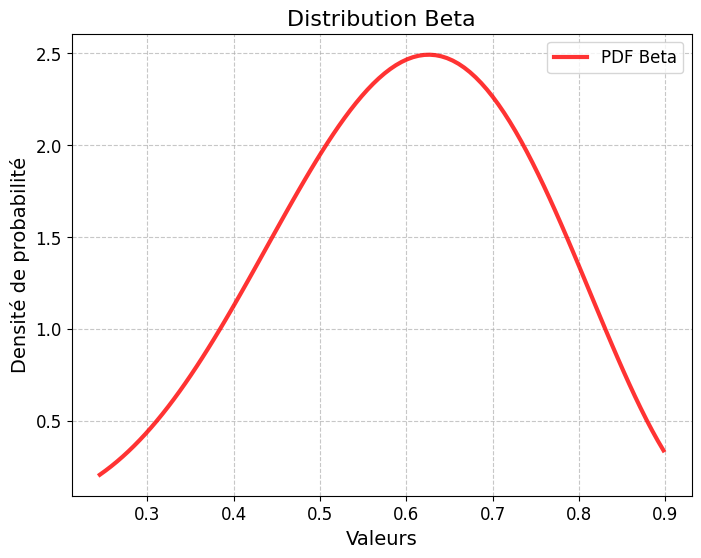

In [6]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def plot_beta_distribution(a_chapeau, b_chapeau):
    """
    Affiche un graphique de la distribution Beta avec les paramètres donnés.

    Paramètres :
    a_chapeau : float : paramètre alpha de la distribution Beta
    b_chapeau : float : paramètre beta de la distribution Beta
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    x = np.linspace(beta.ppf(0.01, a_chapeau, b_chapeau),
                    beta.ppf(0.99, a_chapeau, b_chapeau), 100)
    y = beta.pdf(x, a_chapeau, b_chapeau)

    ax.plot(x, y, 'r-', lw=3, alpha=0.8, label='PDF Beta')

    ax.set_title('Distribution Beta', fontsize=16)
    ax.set_xlabel('Valeurs', fontsize=14)
    ax.set_ylabel('Densité de probabilité', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)

    plt.show()

plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp)

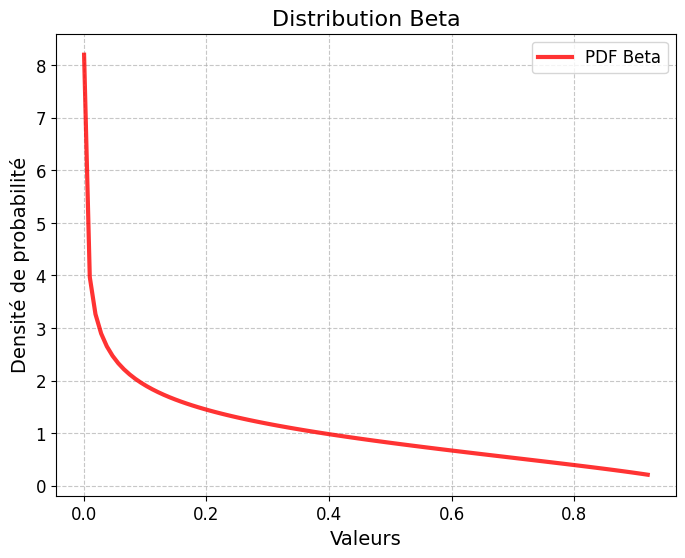

In [7]:
plot_beta_distribution(a_chapeau_sg, b_chapeau_sg)

# 3. On s’intéresse à l’historique des données actions. 
## 3.a. Effectuer une analyse exploratoire univariée des données actions de ces deux entreprises

In [8]:
# Chargement des données
data = pd.read_csv("data.txt", sep="\s+", header=0)
data.head()

BNP     SG
0  42.36  55.24
1  42.72  55.59
2  43.20  56.45
3  42.67  55.55
4  41.81  54.50

In [9]:
data.describe()

BNP           SG
count  1000.000000  1000.000000
mean     31.906254    43.532641
std       9.630129    10.007847
min      14.056200    21.667700
25%      23.450325    36.065350
50%      34.353700    46.824800
75%      40.229375    51.291675
max      48.330000    60.680000

In [10]:
data_returns = np.log(data/data.shift(1)).dropna()
data_returns.head(3)

BNP        SG
1  0.008463  0.006316
2  0.011173  0.015352
3 -0.012344 -0.016072

In [11]:
data_returns.describe()

BNP          SG
count  999.000000  999.000000
mean    -0.000888   -0.000687
std      0.024441    0.020731
min     -0.123524   -0.098292
25%     -0.013867   -0.011830
50%     -0.000358   -0.000547
75%      0.012526    0.011223
max      0.083225    0.076478

In [12]:
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

def analyze_data(df, name="Dataset"):
    """
    Analyse les données du DataFrame fourni et retourne un DataFrame avec :
    - Statistiques descriptives
    - Tests de normalité (Shapiro-Wilk)
    - Tests de stationnarité (Dickey-Fuller)

    Paramètres :
    df : DataFrame : Doit contenir les colonnes 'Close' et 'Rendement'
    name : str : Nom du dataset (optionnel)

    Retourne :
    results : DataFrame avec toutes les analyses
    """
    # Vérification de la présence des colonnes nécessaires
    if not {'Close', 'Rendement'}.issubset(df.columns):
        raise ValueError("Le DataFrame doit contenir les colonnes 'Close' et 'Rendement'.")

    # Statistiques descriptives
    results = df[['Close', 'Rendement']].describe()
    results['Indicateur'] = ["Nombre", "Moyenne", "Ecart-Type", "Minimum", "Percentile 25%", "Médiane", "Percentile 75%", "Maximum"]
    results = results[['Indicateur', 'Close', 'Rendement']]

    # Test de normalité (Shapiro-Wilk)
    _, p_rend = shapiro(df['Rendement'].dropna())
    _, p_close = shapiro(df['Close'].dropna())
    results = pd.concat([results, pd.DataFrame([["Normalité (p)", p_close, p_rend]], columns=results.columns)])

    # Test de stationnarité (Dickey-Fuller)
    _, p_value_rend = adfuller(df['Rendement'].dropna())[:2]
    _, p_value_close = adfuller(df['Close'].dropna())[:2]
    results = pd.concat([results, pd.DataFrame([["Stationnarité (p)", p_value_close, p_value_rend]], columns=results.columns)])

    return results

data_bnp = pd.concat([data["BNP"], data_returns["BNP"]], axis=1)
data_bnp.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_bnp)

Indicateur         Close     Rendement
count             Nombre  1.000000e+03  9.990000e+02
mean             Moyenne  3.190625e+01 -8.875748e-04
std           Ecart-Type  9.630129e+00  2.444100e-02
min              Minimum  1.405620e+01 -1.235235e-01
25%       Percentile 25%  2.345032e+01 -1.386684e-02
50%              Médiane  3.435370e+01 -3.578458e-04
75%       Percentile 75%  4.022938e+01  1.252624e-02
max              Maximum  4.833000e+01  8.322452e-02
0          Normalité (p)  2.361886e-21  7.315078e-12
0      Stationnarité (p)  7.943908e-01  0.000000e+00

In [13]:
data_sg = pd.concat([data["SG"], data_returns["SG"]], axis=1)
data_sg.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_sg)

Indicateur         Close     Rendement
count             Nombre  1.000000e+03  9.990000e+02
mean             Moyenne  4.353264e+01 -6.874575e-04
std           Ecart-Type  1.000785e+01  2.073120e-02
min              Minimum  2.166770e+01 -9.829201e-02
25%       Percentile 25%  3.606535e+01 -1.182979e-02
50%              Médiane  4.682480e+01 -5.468895e-04
75%       Percentile 75%  5.129167e+01  1.122288e-02
max              Maximum  6.068000e+01  7.647830e-02
0          Normalité (p)  2.019151e-20  4.726505e-12
0      Stationnarité (p)  7.361591e-01  8.678531e-09

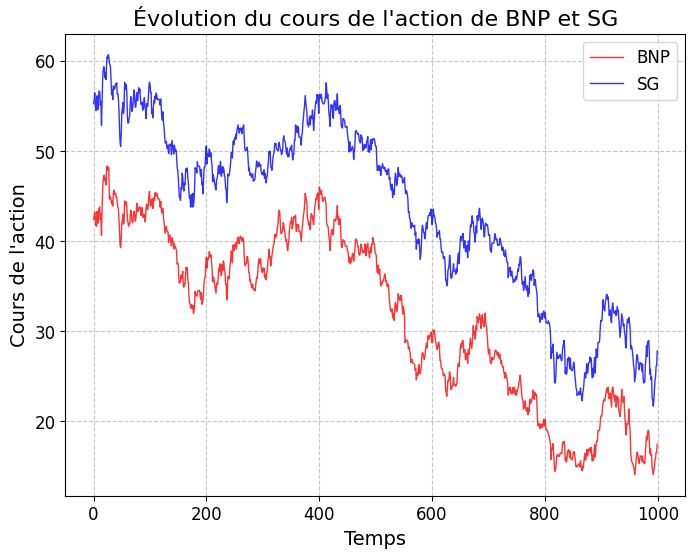

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(data["BNP"], 'r-', lw=1, alpha=0.8, label='BNP')
ax.plot(data["SG"], 'b-', lw=1, alpha=0.8, label='SG')
ax.set_title("Évolution du cours de l'action de BNP et SG", fontsize=16)
ax.set_xlabel('Temps', fontsize=14)
ax.set_ylabel("Cours de l'action", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=12)
plt.show()

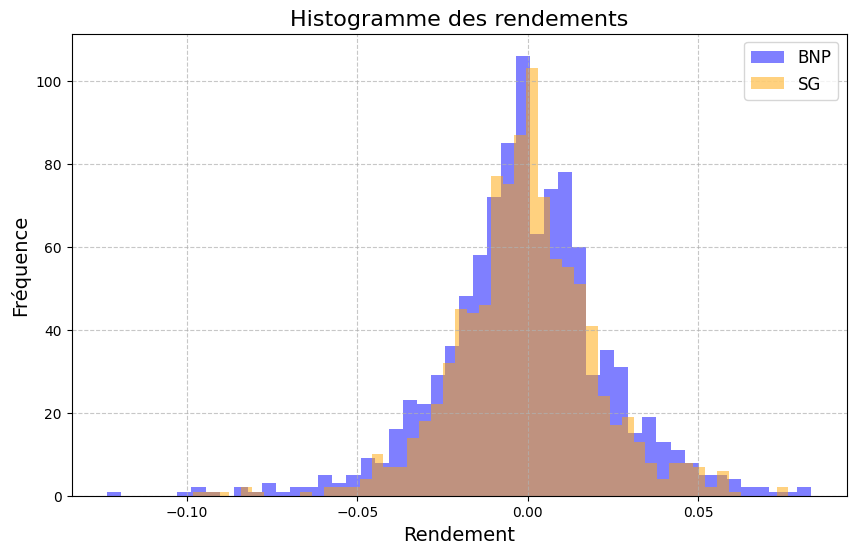

In [15]:
# Création de la figure et des axes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Création de l'histogramme
ax.hist(data_returns['BNP'], bins=50, alpha=0.5, label="BNP", color='blue')
ax.hist(data_returns['SG'], bins=50, alpha=0.5, label="SG", color='orange')
# Ajout du titre et des légendes
ax.set_title("Histogramme des rendements", fontsize=16)
ax.set_xlabel("Rendement", fontsize=14)
ax.set_ylabel("Fréquence", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
# Personnalisation de la grille
ax.grid(True, linestyle='--', alpha=0.7)
# Affichage du graphique
plt.show()

## 3.b Modéliser judicieusement les distributions univariées des facteurs de risques

In [16]:
def skew_t_pdf(x, params):
    """
    Densité de probabilité de la loi Skew Student.

    Paramètres :
    - x : Valeurs pour lesquelles calculer la densité.
    - mu : Moyenne de la distribution.
    - nu : Degrés de liberté de la loi t.
    - sigma : Écart-type de la distribution.
    - gamma : Paramètre de skewness (asymétrie).

    Retour :
    - La densité de probabilité pour chaque valeur de x.
    """
    mu, nu, sigma, gamma = params
    # Calcul de la densité de la loi Student standard avec nu degrés de liberté
    z = (x - mu) / sigma
    student_pdf = t.pdf(x, df=nu, loc = mu, scale=sigma)

    # Calcul de la CDF de la Student avec (nu + 1) degrés de liberté, et ajustement avec gamma
    student_cdf = t.cdf(gamma*z*np.sqrt((nu+1)/(z**2 + nu)), df=nu + 1)

    # Retour de la densité de la Skew-Student avec facteur d'asymétrie
    return 2 * student_pdf * student_cdf

In [17]:
def neg_log_likelihood(params, x):
    """Log-vraisemblance négative à minimiser"""
    mu, nu, sigma, gamma = params

    return -np.sum(np.log(np.maximum(skew_t_pdf(x, params), 10e-10)))

In [18]:
def estimate_skew_t_params(x):
    """Estimation des paramètres par maximum de vraisemblance"""
    init_params = [0, 2, 0.1, 0]  # Initialisation
    bounds = [(0, None), (2, None), (10e-6, None), (-1, 1)]

    result = minimize(neg_log_likelihood, init_params, args=(x,), bounds=bounds, method='L-BFGS-B')

    if result.success:
        return result.x
    else:
        raise ValueError("L'optimisation a échoué.")

In [19]:
from scipy.special import gamma as gamma_func

# -----------------------------------------------------------------------------
# Fonctions de la loi t et de sa version généralisée
# -----------------------------------------------------------------------------

def student_pdf(x, nu):
    """
    Densité de la loi t standard à nu degrés de liberté.
    """
    coeff = gamma_func((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma_func(nu / 2))
    return coeff * (1 + x**2 / nu) ** (-(nu + 1) / 2)

def student_cdf(x, nu):
    """
    Fonction de répartition de la loi t standard.
    """
    return t.cdf(x, df=nu)

def student_gen_pdf(x, mu, sigma, nu):
    """
    Densité de la loi t généralisée.
    """
    z = (x - mu) / sigma
    coeff = gamma_func((nu + 1) / 2) / (sigma * np.sqrt((nu - 2) * np.pi) * gamma_func(nu / 2))
    return coeff * (1 + z**2 / (nu - 2)) ** (-(nu + 1) / 2)

def student_gen_cdf(x, mu, sigma, nu):
    """
    Fonction de répartition de la loi t généralisée.
    Transformation selon : y = (x - mu) / (sigma * sqrt((nu - 2) / nu))
    """
    sigma_v = sigma * np.sqrt((nu - 2) / nu) 
    z = (x - mu) / sigma_v
    return t.cdf(z, df=nu)

# -----------------------------------------------------------------------------
# Densité de la loi Skew-Student
# -----------------------------------------------------------------------------

def skew_student_pdf(x, mu, sigma, gamma, nu):
    """
    Densité de la loi skew-t selon Hansen.
    """
    z = (x - mu) / sigma
    f_sym = student_gen_pdf(x, mu, sigma, nu)
    gamma_arg = gamma * z * np.sqrt((nu + 1) / (nu + z**2))
    gamma_cdf = t.cdf(gamma_arg, df=nu + 1)
    return 2 * f_sym * gamma_cdf

# -----------------------------------------------------------------------------
# Vraisemblance et estimation par Maximum de Vraisemblance (MLE)
# -----------------------------------------------------------------------------

def log_likelihood_skew_student(params, data):
    """
    Calcule le log-vraisemblance négatif pour un échantillon donné.
    """
    mu, sigma, gamma, nu = params
    log_likelihood = 0
    for x in data:
        pdf_val = skew_student_pdf(x, mu, sigma, gamma, nu)
        if pdf_val <= 0 or np.isnan(pdf_val):
            return np.inf
        log_likelihood += np.log(pdf_val)
    return -log_likelihood

def fit_skew_student_mle(data):
    """
    Estime les paramètres (mu, sigma, gamma, nu) par Maximum de Vraisemblance.
    """
    initial_guess = (np.mean(data), np.std(data), 0.5, 4.0)
    bounds = [(None, None), (1e-6, None), (None, None), (2, None)]
    result = minimize(log_likelihood_skew_student, initial_guess, args=(data,), method="L-BFGS-B", bounds=bounds)
    
    if not result.success:
        raise RuntimeError("L'optimisation a échoué : " + result.message)
    
    return result.x  # Renvoie (mu, sigma, gamma, nu)

In [20]:
try:
    params_estimated_bnp = fit_skew_student_mle(data_returns["BNP"].dropna())
    print("Paramètres estimés BNP (mu, sigma, gamma, nu) :", params_estimated_bnp)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

Paramètres estimés BNP (mu, sigma, gamma, nu) : [ 1.27623299e-03  2.50545660e-02 -1.34745851e-01  4.56957665e+00]


In [21]:
try:
    params_estimated_sg = fit_skew_student_mle(data_returns["SG"].dropna())
    print("Paramètres estimés SG (mu, sigma, gamma, nu) :", params_estimated_sg)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

Paramètres estimés SG (mu, sigma, gamma, nu) : [-1.42354772e-03  2.17975944e-02  6.43053433e-02  4.06704948e+00]


In [22]:
"""
mu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())
print(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")
"""

'\nmu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())\nprint(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")\n'

In [23]:
"""
mu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())
print(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")
"""

'\nmu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())\nprint(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")\n'

In [24]:
"""
mu_sg, nu_sg, sigma_sg, gamma_sg = estimate_skew_t_params(data_returns["SG"].dropna())
print(f"Paramètres estimés pour SG : mu = {mu_sg:.4f}, nu = {nu_sg:.4f}, sigma = {sigma_sg:.4f}, gamma = {gamma_sg:.4f}")
"""

'\nmu_sg, nu_sg, sigma_sg, gamma_sg = estimate_skew_t_params(data_returns["SG"].dropna())\nprint(f"Paramètres estimés pour SG : mu = {mu_sg:.4f}, nu = {nu_sg:.4f}, sigma = {sigma_sg:.4f}, gamma = {gamma_sg:.4f}")\n'

In [25]:
"""
def skew_student_quantile(params, prob, size=100000):

    mu, nu, sigma, gamma = params
    T_g1 = stats.t.rvs(df=nu, size=size)
    T_g2 = stats.t.rvs(df=nu, size=size)

    Z = mu + sigma / np.sqrt(1 + gamma**2) * (gamma * T_g1 + T_g2)

    return np.percentile(Z, 100 * (prob))
"""

'\ndef skew_student_quantile(params, prob, size=100000):\n\n    mu, nu, sigma, gamma = params\n    T_g1 = stats.t.rvs(df=nu, size=size)\n    T_g2 = stats.t.rvs(df=nu, size=size)\n\n    Z = mu + sigma / np.sqrt(1 + gamma**2) * (gamma * T_g1 + T_g2)\n\n    return np.percentile(Z, 100 * (prob))\n'

In [26]:
# -----------------------------------------------------------------------------
# Création de la fonction inverse de la CDF (fonction quantile) par intégration
# par la méthode des trapèzes (vectorisée, sans appel à quad)
# -----------------------------------------------------------------------------

def create_skew_student_inverse_cdf(params, lower, upper, num_points=10000):
    """
    Construit une approximation de la fonction quantile pour la loi Skew-Student
    en créant une grille d'intégration par la méthode des trapèzes.
    
    params    : (mu, sigma, gamma, nu)
    lower     : borne inférieure de la grille
    upper     : borne supérieure de la grille
    num_points: nombre de points sur la grille
    """
    mu, sigma, gamma, nu = params
    x_grid = np.linspace(lower, upper, num_points)
    pdf_vals = skew_student_pdf(x_grid, mu, sigma, gamma, nu)
    
    # Intégration cumulative par la méthode des trapèzes
    dx = x_grid[1] - x_grid[0]
    cdf_vals = np.cumsum(pdf_vals) * dx
    # Normaliser pour que la dernière valeur soit 1
    cdf_vals /= cdf_vals[-1]
    
    # Retourne une fonction qui, pour une probabilité p, interpole le quantile correspondant
    def inverse_cdf(p):
        return np.interp(p, cdf_vals, x_grid)
    
    return inverse_cdf

# -----------------------------------------------------------------------------
# Fonction pour afficher le QQ-plot sans utiliser d'intégrales à chaque quantile
# -----------------------------------------------------------------------------

def qq_plot(x, params):
    """
    QQ-plot pour comparer les quantiles empiriques et théoriques d'une loi Skew‑Student.
    
    Paramètres :
      - x      : vecteur de données (ex : rendements)
      - params : paramètres (mu, sigma, gamma, nu) de la loi Skew‑Student
    """
    sorted_x = np.sort(x)
    n = len(x)
    
    # Définir les bornes pour la grille en se basant sur les données empiriques
    lower = np.min(sorted_x) - 2 * np.std(sorted_x)
    upper = np.max(sorted_x) + 2 * np.std(sorted_x)
    
    # Créer la fonction inverse de la CDF (quantile) sur une grille
    inv_cdf = create_skew_student_inverse_cdf(params, lower, upper, num_points=10000)
    
    # Calcul des probabilités associées aux quantiles
    p_vals = np.linspace(1/n, 1, n)
    theoretical_quantiles = inv_cdf(p_vals)
    
    # Affichage du QQ-plot
    plt.figure(figsize=(6,6))
    plt.scatter(theoretical_quantiles, sorted_x, label="Données empiriques")
    plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label="Ligne x = y")
    plt.xlabel("Quantiles théoriques (Skew‑Student)")
    plt.ylabel("Quantiles empiriques")
    plt.legend()
    plt.title("QQ-plot Skew‑Student")
    plt.show()

Paramètres estimés BNP (mu, sigma, gamma, nu) : [ 1.27623299e-03  2.50545660e-02 -1.34745851e-01  4.56957665e+00]


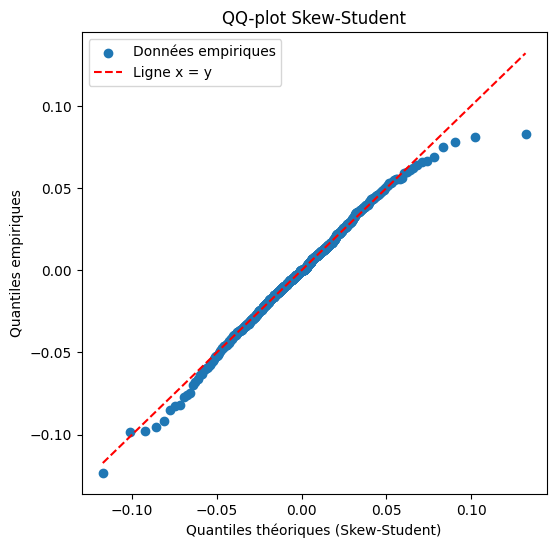

In [27]:
try:
    # Estimation des paramètres (en enlevant les valeurs manquantes)
    params_estimated_bnp = fit_skew_student_mle(data_returns["BNP"].dropna())
    print("Paramètres estimés BNP (mu, sigma, gamma, nu) :", params_estimated_bnp)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

# Affichage du QQ-plot avec les paramètres estimés
qq_plot(data_returns["BNP"].dropna(), params_estimated_bnp)


Paramètres estimés SG (mu, sigma, gamma, nu) : [-1.42354772e-03  2.17975944e-02  6.43053433e-02  4.06704948e+00]


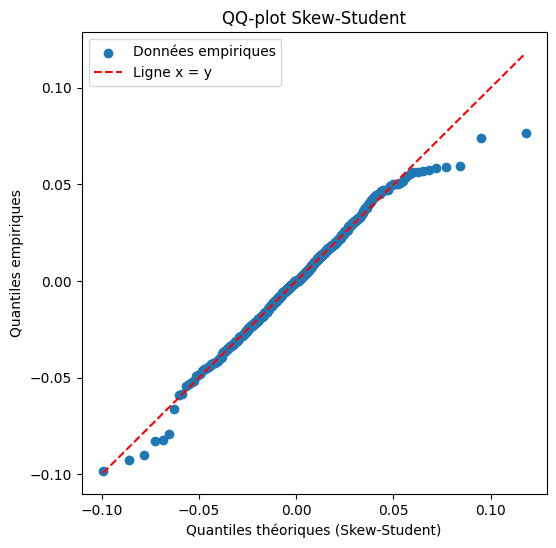

In [28]:
try:
    # Estimation des paramètres (en enlevant les valeurs manquantes)
    params_estimated_sg = fit_skew_student_mle(data_returns["SG"].dropna())
    print("Paramètres estimés SG (mu, sigma, gamma, nu) :", params_estimated_sg)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

# Affichage du QQ-plot avec les paramètres estimés
qq_plot(data_returns["SG"].dropna(), params_estimated_sg)


In [29]:
# e. Calcul de la VaR Skew-Student à 99%
def var_skew_t(alpha, params):
    """
    Calcul de la VaR à alpha% pour une loi Skew-Student en utilisant 
    l'approximation de la fonction quantile (inverse CDF).
    """
    mu, sigma, gamma, nu = params
    
    # Définir les bornes pour la grille en fonction des paramètres
    lower = mu - 5 * sigma
    upper = mu + 5 * sigma
    
    # Créer la fonction inverse de la CDF sur une grille
    inv_cdf = create_skew_student_inverse_cdf(params, lower, upper, num_points=10000)
    
    # Calcul de la VaR (1 - alpha) quantile
    return inv_cdf(1 - alpha)

# Calcul de la VaR à 99% pour BNP et SG
params_bnp = (params_estimated_bnp)
params_sg = (params_estimated_sg)

var_99_bnp = var_skew_t(0.99, params_bnp)
var_99_sg = var_skew_t(0.99, params_sg)

print(f"VaR Skew-Student à 99% de BNP : {var_99_bnp:.4f}")
print(f"VaR Skew-Student à 99% de SG  : {var_99_sg:.4f}")


VaR Skew-Student à 99% de BNP : -0.0663
VaR Skew-Student à 99% de SG  : -0.0560


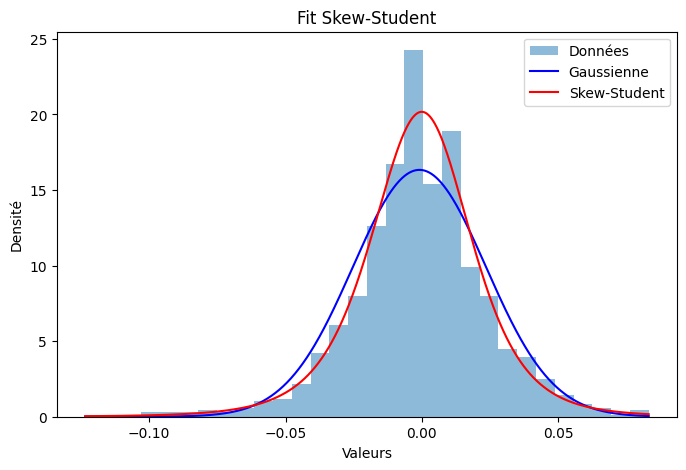

In [30]:
# d. Comparaison des fits
def plot_fit_comparison(x, params_skew_t):
    """Comparaison des fits entre la loi gaussienne et la loi Skew-Student."""
    plt.figure(figsize=(8,5))
    # Histogramme des données
    plt.hist(x, bins=30, density=True, alpha=0.5, label="Données")
    # Densité gaussienne
    mu_norm, sigma_norm = np.mean(x), np.std(x)
    x_vals = np.linspace(min(x), max(x), 1000)
    plt.plot(x_vals, stats.norm.pdf(x_vals, mu_norm, sigma_norm), label="Gaussienne", color='blue')
    # Densité Skew-Student
    plt.plot(x_vals, skew_student_pdf(x_vals, params_skew_t[0], params_skew_t[1], params_skew_t[2],params_skew_t[3]),
              label="Skew-Student", color='red')
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.title("Fit Skew-Student")
    plt.show()

plot_fit_comparison(data_returns["BNP"].dropna(), params_estimated_bnp)

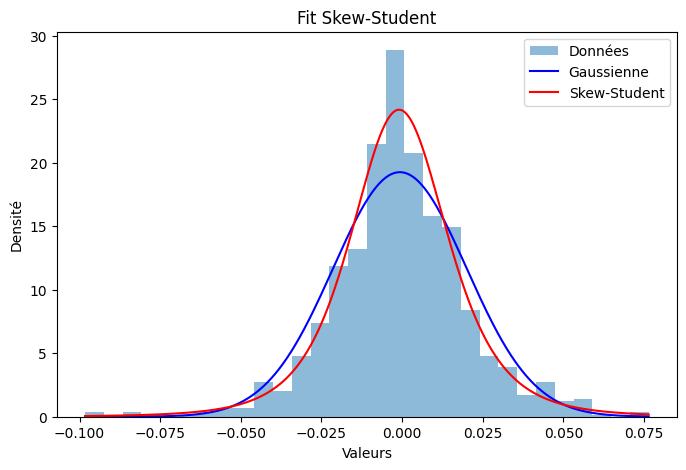

In [31]:
plot_fit_comparison(data_returns["SG"].dropna(), params_estimated_sg)

### Normale Inverse Gaussienne

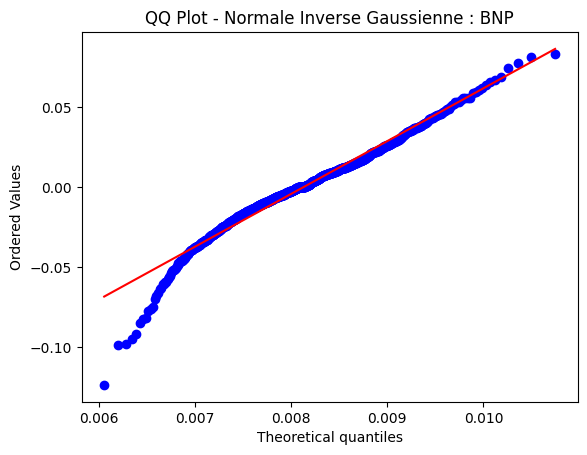

In [32]:
# Ajustement de la distribution normale inverse gaussienne
params_bnp = stats.invgauss.fit(data_returns["BNP"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["BNP"], dist="invgauss", sparams=params_bnp[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

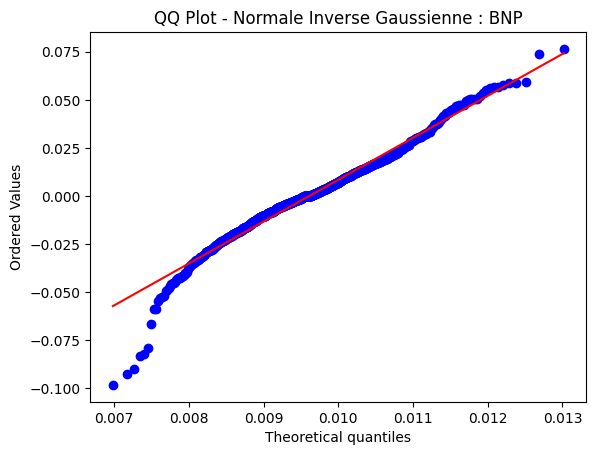

In [33]:
# Ajustement de la distribution normale inverse gaussienne
params_sg = stats.invgauss.fit(data_returns["SG"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["SG"], dist="invgauss", sparams=params_sg[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

Corrélation de Pearson :
           BNP        SG
BNP  1.000000  0.863498
SG   0.863498  1.000000
Corrélation de Spearman :
           BNP        SG
BNP  1.000000  0.840957
SG   0.840957  1.000000
Corrélation de Kendall :
           BNP        SG
BNP  1.000000  0.669096
SG   0.669096  1.000000


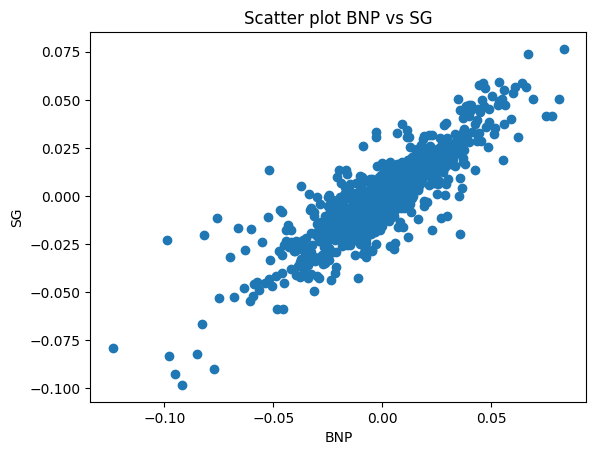

In [34]:
# Calcul des corrélations
print("Corrélation de Pearson :\n", data_returns.corr(method="pearson"))
print("Corrélation de Spearman :\n", data_returns.corr(method="spearman"))
print("Corrélation de Kendall :\n", data_returns.corr(method="kendall"))

# Nuage de points
plt.scatter(data_returns['BNP'], data_returns['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

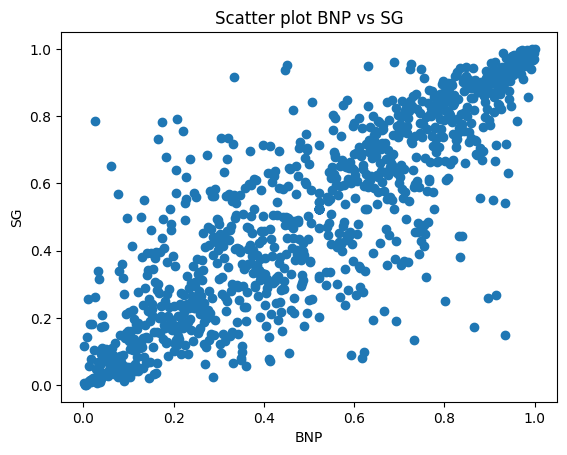

In [35]:
data_uniform = data_returns.rank(method='average', pct=True)
# Nuage de points
plt.scatter(data_uniform['BNP'], data_uniform['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes :

## 5.a. Copules elliptiques : gaussienne, Student. 

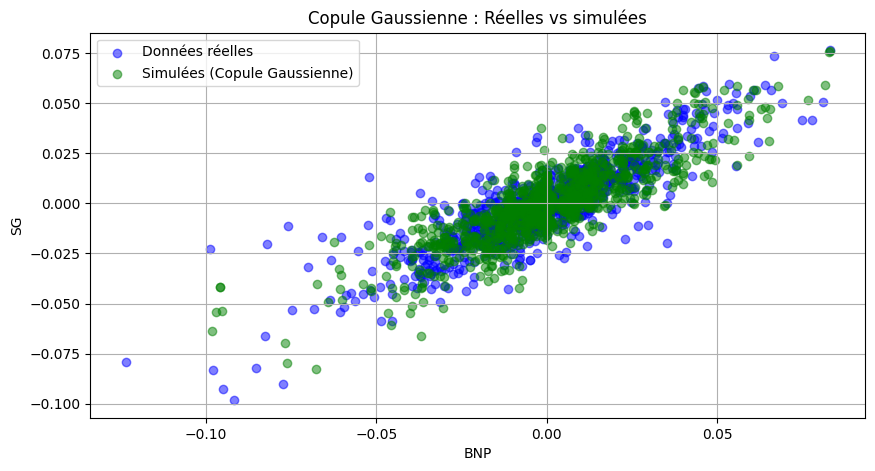

In [36]:
from copulae import GaussianCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Gaussienne sur les rangs
copula_gaussian = GaussianCopula(dim=2)  # 2 variables
copula_gaussian.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_gaussian.random(len(data_returns))

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument les pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Gaussienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gaussienne : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()


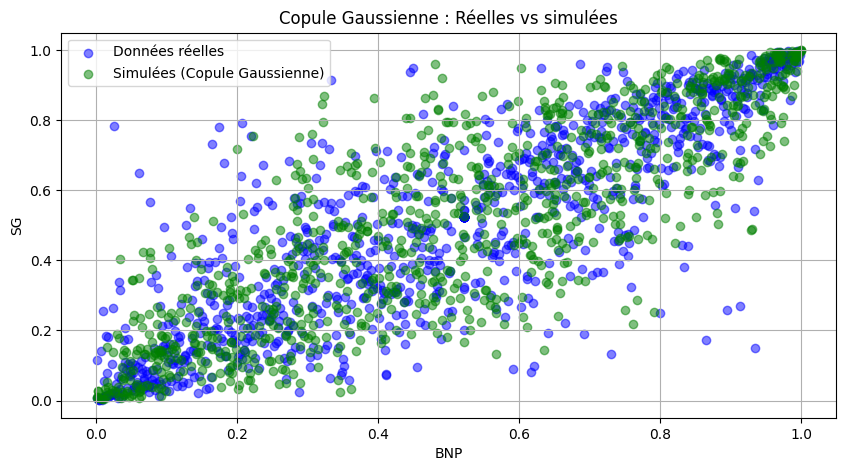

In [37]:
# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Gaussienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gaussienne : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
copula_gaussian.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
1.000000 0.860948
0.860948 1.000000

# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes : 

## Copules elliptiques : gaussienne, Student.

e:\ENSAI\ENSAI 3A\Gestion des risques multiples\Projet\Gestion-des-Risques-Multiples\myenv\Lib\site-packages\copulae\stats\_multivariate_t.py:195: RuntimeWarning: divide by zero encountered in divide
  r /= d


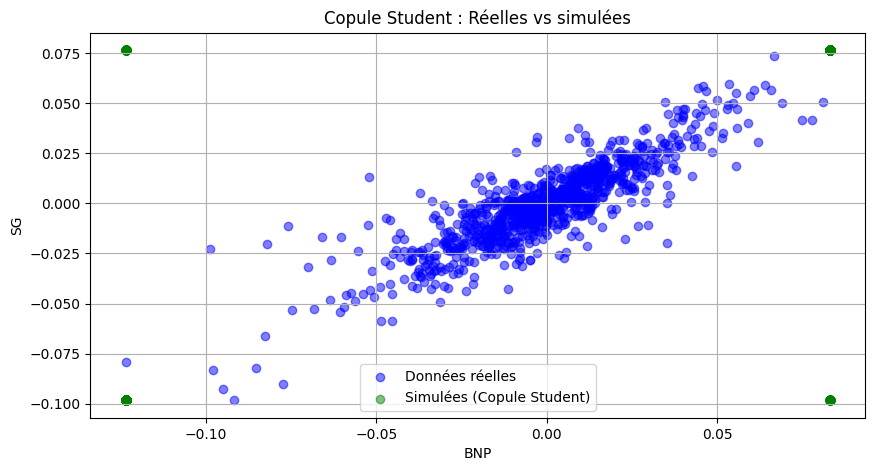

In [39]:
from copulae import StudentCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Student sur les rangs
copula_student = StudentCopula(dim=2)  # 2 variables
copula_student.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_student.random(len(data_returns['BNP']))

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument les pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Student)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Student : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

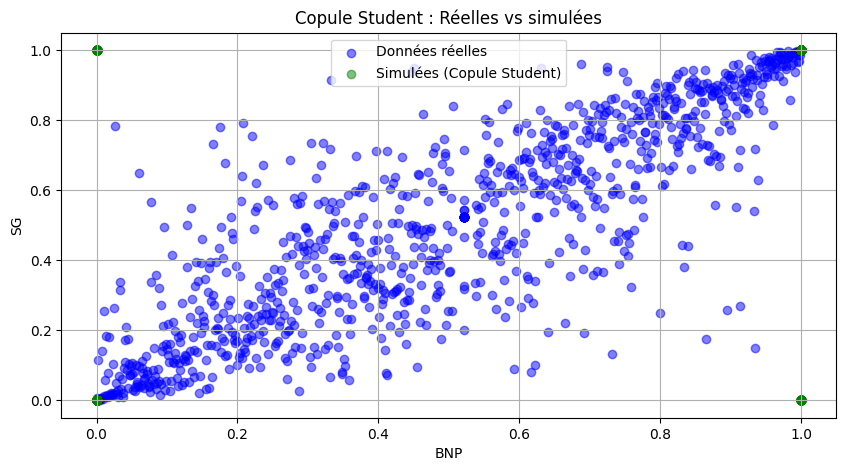

In [40]:
# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Student)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Student : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
copula_student.summary()

Student Copula Summary
================================================================================
Student Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 6.4286354017895064e-12

 Correlation Matrix 
1.000000 0.849184
0.849184 1.000000

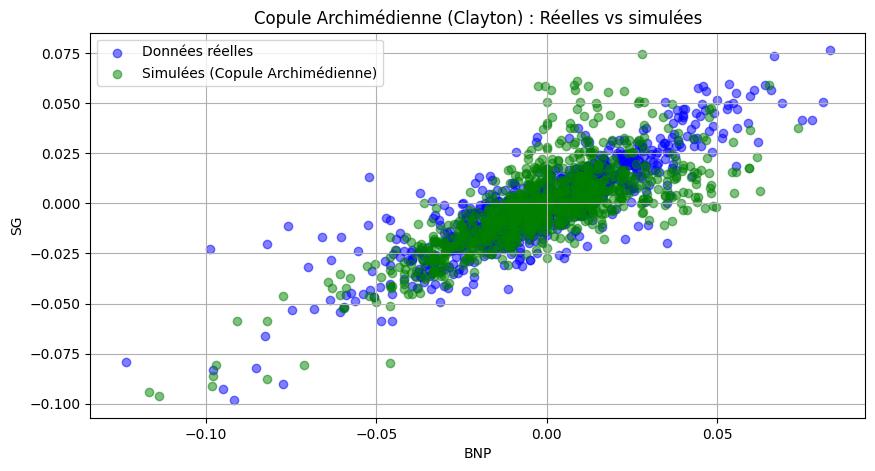

In [42]:
from copulae import ClaytonCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Archimédienne (ici, la ClaytonCopula) sur les rangs
copula_arch = ClaytonCopula(dim=2)  # 2 variables : 'BNP' et 'SG'
copula_arch.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs dans [0, 1])
samples = copula_arch.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument des pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Archimédienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Archimédienne (Clayton) : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

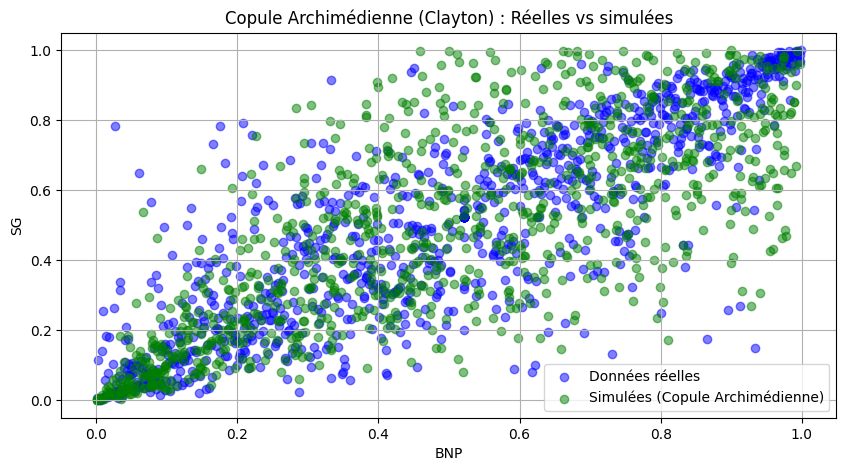

In [43]:
# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Archimédienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Archimédienne (Clayton) : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
copula_arch.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.476781735562753

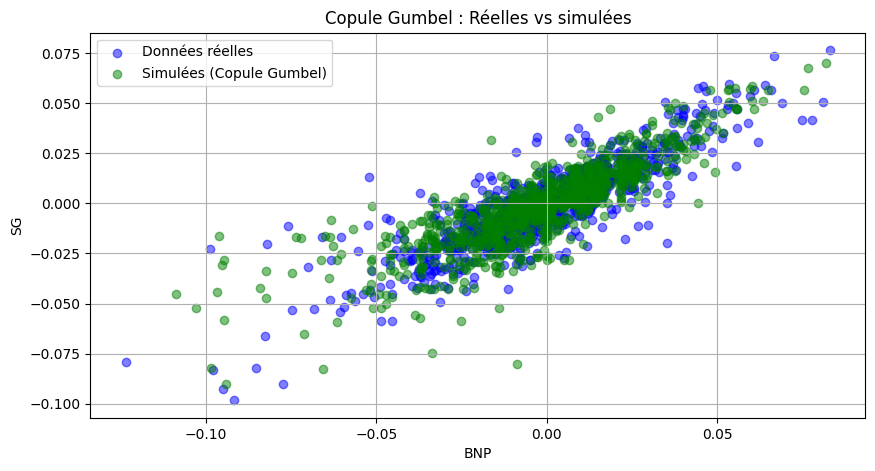

In [45]:
from copulae import GumbelCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Gumbel sur les rangs
copula_gumbel = GumbelCopula(dim=2)  # 2 variables
copula_gumbel.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_gumbel.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument des pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Gumbel)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gumbel : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

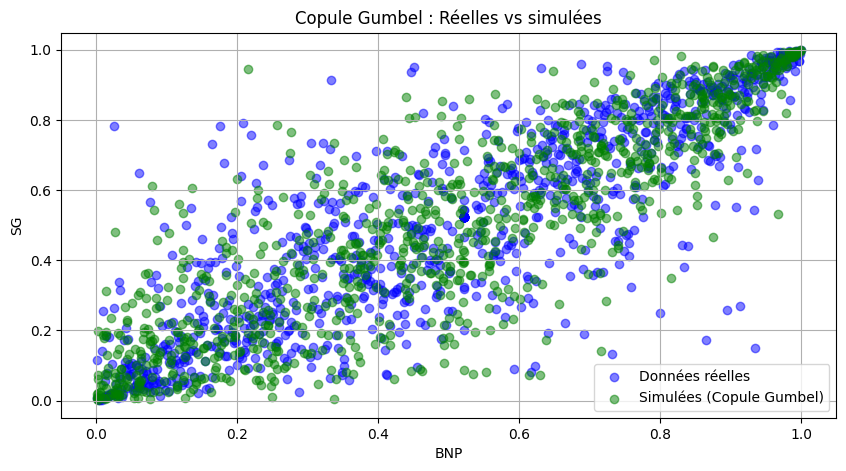

In [46]:
# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Gumbel)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gumbel : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
copula_gumbel.summary()

Gumbel Copula Summary
================================================================================
Gumbel Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.9939137019539217

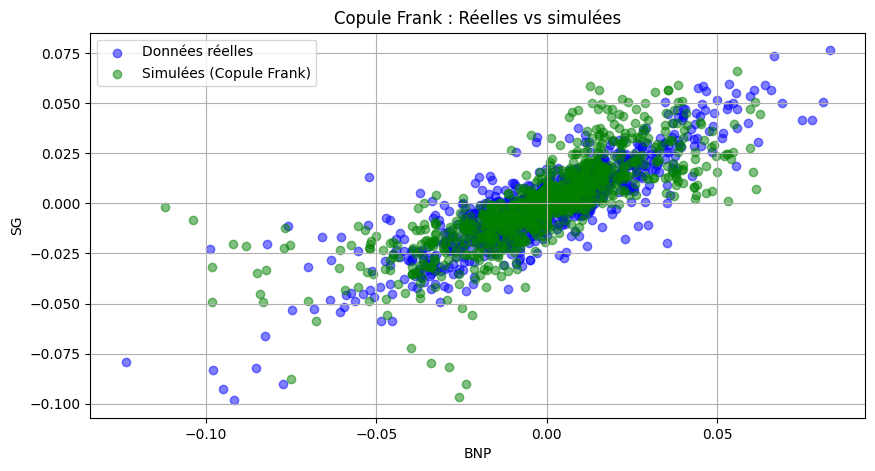

In [48]:
from copulae import FrankCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule de Frank sur les rangs
copula_frank = FrankCopula(dim=2)  # 2 dimensions
copula_frank.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_frank.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Frank)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Frank : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

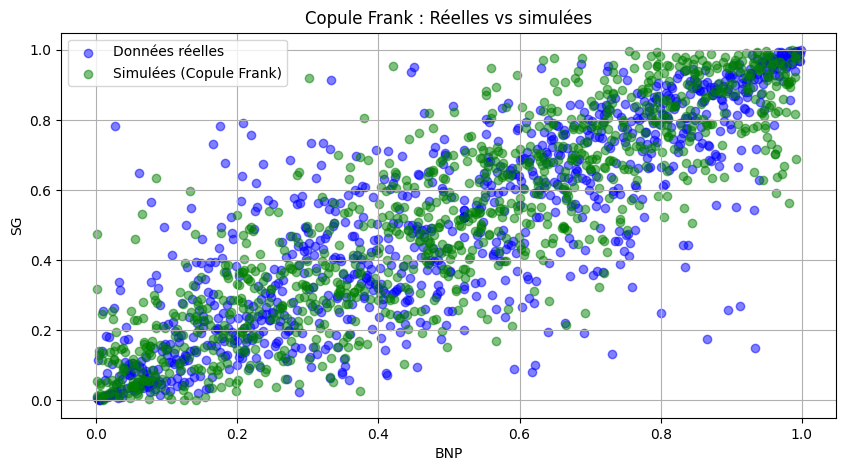

In [49]:
# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Frank)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Frank : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
copula_frank.summary()

Frank Copula Summary
================================================================================
Frank Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 10.127240819074121

In [115]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist
from scipy.optimize import minimize
from math import log, gamma, pi, sqrt

# =============================================================================
# 1) Fonctions de densité t-Student (univariée & bivariée) en log
# =============================================================================

def log_t_pdf_univariate(x, df):
    """
    Retourne ln[f_nu(x)] pour la loi t univariée de df degrés de liberté.
    Formule :
      f_nu(x) = Gamma((df+1)/2) / [ sqrt(df*pi)*Gamma(df/2) ] * [1 + x^2/df]^(-(df+1)/2)
    """
    c1 = np.log(gamma((df+1)/2)) - np.log(gamma(df/2)) - 0.5*np.log(df*pi)
    c2 = -(df+1)/2 * np.log(1 + x**2/df)
    return c1 + c2

def log_t_pdf_bivariate(x, y, df, r):
    """
    Retourne ln[f_{df,r}(x,y)] pour la t-Student bivariée, corrélation r, df degrés de liberté.

      f_{df,r}(x,y) =
         Gamma((df+2)/2) / [ Gamma(df/2) * (pi*df) * sqrt(1-r^2) ]
         * [1 + 1/df * (x^2 - 2rxy + y^2)/(1-r^2)]^(-(df+2)/2)

    On renvoie le log de cette densité.
    """
    # Partie constante
    log_num_gamma = np.log(gamma((df+2)/2)) - np.log(gamma(df/2))
    log_denom = np.log(pi*df) + 0.5*np.log(1 - r**2)
    cst = log_num_gamma - log_denom

    # Partie quadratique
    quad = (x**2 - 2*r*x*y + y**2)/(1 - r**2)
    log_noyau = - (df+2)/2 * np.log(1 + quad/df)

    return cst + log_noyau

# =============================================================================
# 2) Log-densité de la copule t-Student (bivariée)
# =============================================================================

def log_student_copula_2d(u1, u2, df, r):
    """
    Calcule ln[c_{df,r}(u1,u2)] = ln f_{df,r}(x,y) - [ln f_df(x) + ln f_df(y)],
    où x = t_{df}^{-1}(u1) et y = t_{df}^{-1}(u2).

    - u1, u2 dans [0,1].
    - df > 0, r in (-1,1).
    """
    # Inversion via la quantile function (ppf) univariée
    x = t_dist.ppf(u1, df)
    y = t_dist.ppf(u2, df)

    # Log densité jointe
    log_joint = log_t_pdf_bivariate(x, y, df, r)
    # Log densités marginales (univariées)
    log_marg_x = log_t_pdf_univariate(x, df)
    log_marg_y = log_t_pdf_univariate(y, df)

    return log_joint - (log_marg_x + log_marg_y)

# =============================================================================
# 3) Log-vraisemblance négative
# =============================================================================

def negative_log_likelihood(params, data):
    """
    Calcule - somme [ ln c_{df,r}(u1,u2) ] sur tout l'échantillon.
    data : array shape (n,2) contenant les (u1,u2) dans [0,1].
    params : (alpha, beta) --> r, df via reparamétrage :

      r  = tanh(alpha)   --> r in (-1,1)
      df = 2 + log(1 + exp(beta))  --> df > 2 (par exemple)
    """
    alpha, beta = params
    r = np.tanh(alpha)  # in (-1,1)
    df = 2.0 + np.log1p(np.exp(beta))  # > 2

    ll = 0.0
    for (u1, u2) in data:
        ll += log_student_copula_2d(u1, u2, df, r)

    return -ll  # On renvoie la -log-vraisemblance

# =============================================================================
# 4) Fonction d'ajustement (fit) par MLE
# =============================================================================

def fit_student_copula_2d(data, alpha0=0.0, beta0=1.0):
    """
    Ajuste la copule t-Student bivariée à un échantillon de pseudo-observations 'data' (n,2).
    Minimisation de la -log-vraisemblance w.r.t. (alpha,beta).
      alpha0, beta0 : valeurs initiales pour (alpha, beta).

    Retourne un dict contenant r, df, logLik, etc.
    """
    res = minimize(
        fun=negative_log_likelihood,
        x0=np.array([alpha0, beta0]),
        args=(data,),
        method='Nelder-Mead'
    )
    alpha_hat, beta_hat = res.x
    r_hat = np.tanh(alpha_hat)
    df_hat = 2.0 + np.log1p(np.exp(beta_hat))

    ll_hat = -res.fun  # log-vraisemblance au point optimum

    return {
        'r': r_hat,
        'df': df_hat,
        'logLik': ll_hat,
        'success': res.success,
        'message': res.message
    }

# =============================================================================
# 5) Utilisation sur données data_returns
# =============================================================================

# 1) Transformer vos rendements en pseudo-observations dans [0,1]
rank_data = data_returns.rank(method='average') / (len(data_returns) + 1)
u_data = rank_data.values  # numpy array de taille (n,2)

# 2) Ajustement de la copule t-Student bivariée par MLE
result = fit_student_copula_2d(u_data, alpha0=0.0, beta0=1.0)

print("=== Estimation Copule t-Student Bivariée ===")
print(f"Paramètre r estimé = {result['r']:.4f}")
print(f"Paramètre df estimé = {result['df']:.4f}")
print(f"Log-vraisemblance  = {result['logLik']:.4f}")
print("Convergence :", result['success'], "|", result['message'])

=== Estimation Copule t-Student Bivariée ===
Paramètre r estimé = 0.8496
Paramètre df estimé = 2.0000
Log-vraisemblance  = 719.7436
Convergence : True | Optimization terminated successfully.


In [113]:
from copulae import GaussianCopula, StudentCopula, GumbelCopula, FrankCopula
from scipy.stats import kendalltau, spearmanr

# Chargement des données
data_returns = data_returns.reset_index(drop=True)

# Transformation en pseudo-observations (rangs normalisés)
rank_data = data_returns.rank() / (len(data_returns) + 1)

# Définition des copules
copules = {
    "Gaussian": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2, df = 2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2)
}

# Ajustement des copules aux données empiriques
fit_results = {}
for name, cop in copules.items():
    if name == "Student-t":
         cop.fit(rank_data.values, fix_df = True)
    else:
        cop.fit(rank_data.values)
    fit_results[name] = cop

# Comparaison des mesures de dépendance
empirical_tau, _ = kendalltau(data_returns["BNP"], data_returns["SG"])
empirical_rho, _ = spearmanr(data_returns["BNP"], data_returns["SG"])

results = []
for name, cop in fit_results.items():
    simulated_data = cop.random(len(data_returns))
    sim_tau, _ = kendalltau(simulated_data[:, 0], simulated_data[:, 1])
    sim_rho, _ = spearmanr(simulated_data[:, 0], simulated_data[:, 1])
    
    # Nouveau calcul de la log-vraisemblance via la densité jointe
    log_likelihood = np.sum(np.log(cop.pdf(rank_data.values)))

    results.append([name, log_likelihood, abs(sim_tau - empirical_tau), abs(sim_rho - empirical_rho)])

# Affichage des résultats
results_df = pd.DataFrame(results, columns=["Copule", "Log-Vraisemblance", "Erreur Kendall Tau", "Erreur Spearman Rho"])
print(results_df.sort_values(by="Log-Vraisemblance", ascending=False))

      Copule  Log-Vraisemblance  Erreur Kendall Tau  Erreur Spearman Rho
1  Student-t         720.838328            0.005420             0.009072
2     Gumbel         703.146279            0.011414             0.019346
0   Gaussian         670.141798            0.006584             0.021248
3      Frank         630.219249            0.005171             0.016985


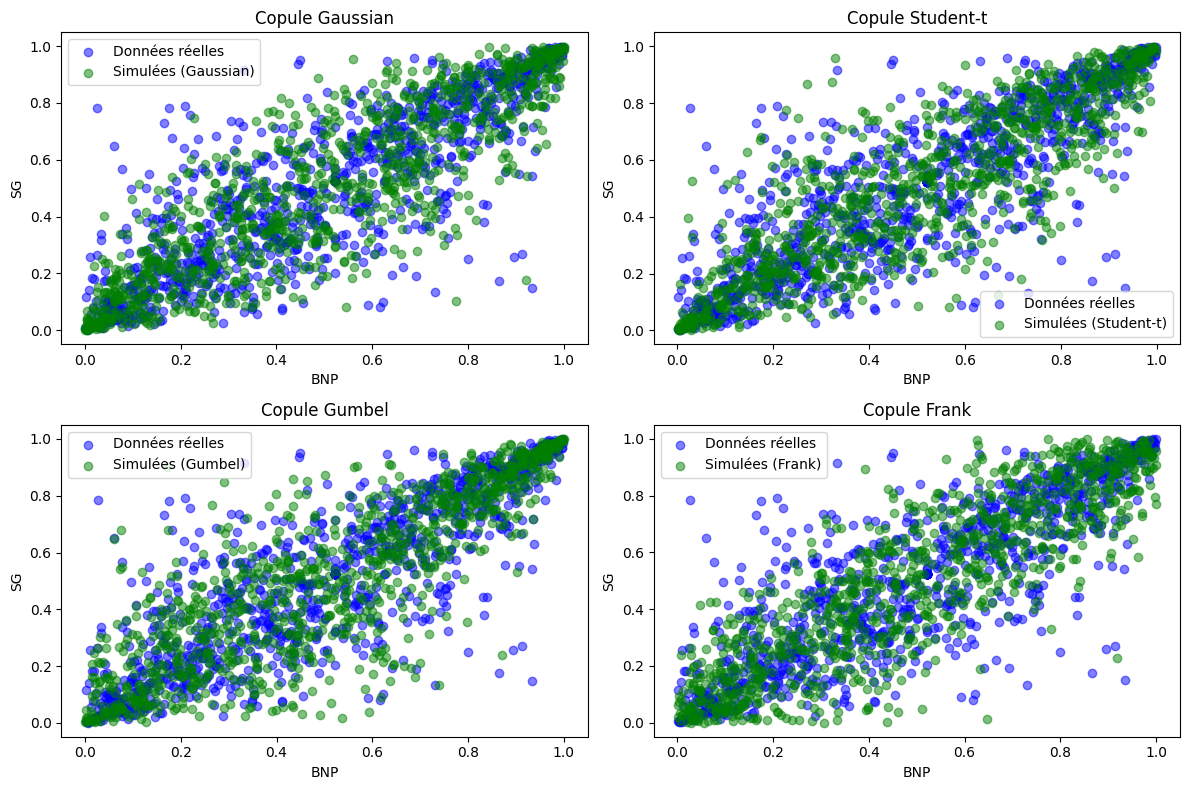

In [114]:
# Visualisation des distributions simulées
plt.figure(figsize=(12, 8))
for i, (name, cop) in enumerate(fit_results.items(), 1):
    simulated_data = cop.random(len(data_returns))
    plt.subplot(2, 2, i)
    plt.scatter(rank_data["BNP"], rank_data["SG"], alpha=0.5, label="Données réelles", color="blue")
    plt.scatter(simulated_data[:, 0], simulated_data[:, 1], alpha=0.5, label=f"Simulées ({name})", color="green")
    plt.title(f"Copule {name}")
    plt.xlabel("BNP")
    plt.ylabel("SG")
    plt.legend()

plt.tight_layout()
plt.show()

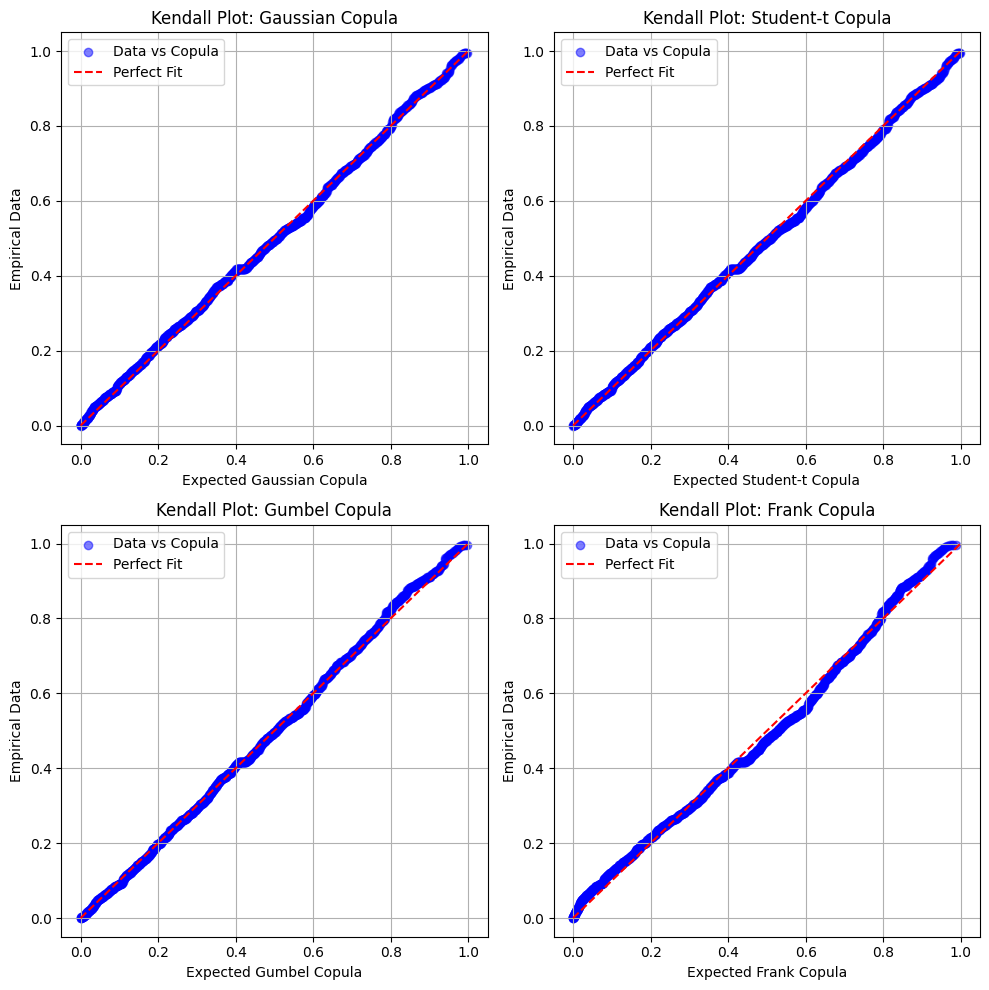

In [ ]:
from copulae import GaussianCopula, StudentCopula
from copulae.archimedean import GumbelCopula, FrankCopula

# Assuming data_returns is a DataFrame with two columns
# Compute pseudo-observations (normalized ranks)
rank_data = data_returns.rank() / (len(data_returns) + 1)
u = rank_data.iloc[:, 0].values
v = rank_data.iloc[:, 1].values
n = len(u)

# Compute empirical V_i (Kendall distribution values)
mask = (u[:, np.newaxis] <= u) & (v[:, np.newaxis] <= v)
counts = mask.sum(axis=1)
V = (counts - 1) / (n - 1)  # Adjust for self-comparison
V_sorted = np.sort(V)

# Define copulas to test
copulas = {
    "Gaussian": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2, df = 2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2)
}

# Simulation parameters
num_simulations = 100  # Increase for smoother results

# Generate Kendall plots
plt.figure(figsize=(10, 10))

for i, (name, copula) in enumerate(copulas.items(), 1):
    # Fit copula to data
    if name == "Student-t":
        copula.fit(rank_data.values, fix_df = True)
    else:
        copula.fit(rank_data.values)
    
    # Simulate multiple datasets and compute V statistics
    simulated_V = np.zeros((num_simulations, n))
    
    for s in range(num_simulations):
        # Generate synthetic data from copula
        sim_data = copula.random(n)
        
        # Compute V for simulated data
        u_sim = sim_data[:, 0]
        v_sim = sim_data[:, 1]
        mask_sim = (u_sim[:, np.newaxis] <= u_sim) & (v_sim[:, np.newaxis] <= v_sim)
        counts_sim = mask_sim.sum(axis=1)
        V_sim = (counts_sim - 1) / (n - 1)
        simulated_V[s] = np.sort(V_sim)  # Sort each simulation
    
    # Calculate expected values across simulations
    expected_V = simulated_V.mean(axis=0)
    
    # Create Kendall plot
    plt.subplot(2, 2, i)
    plt.scatter(expected_V, V_sorted, alpha=0.5, color='blue', label='Data vs Copula')
    plt.plot([0, 1], [0, 1], '--r', label='Perfect Fit')
    plt.xlabel(f'Expected {name} Copula')
    plt.ylabel('Empirical Data')
    plt.title(f'Kendall Plot: {name} Copula')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

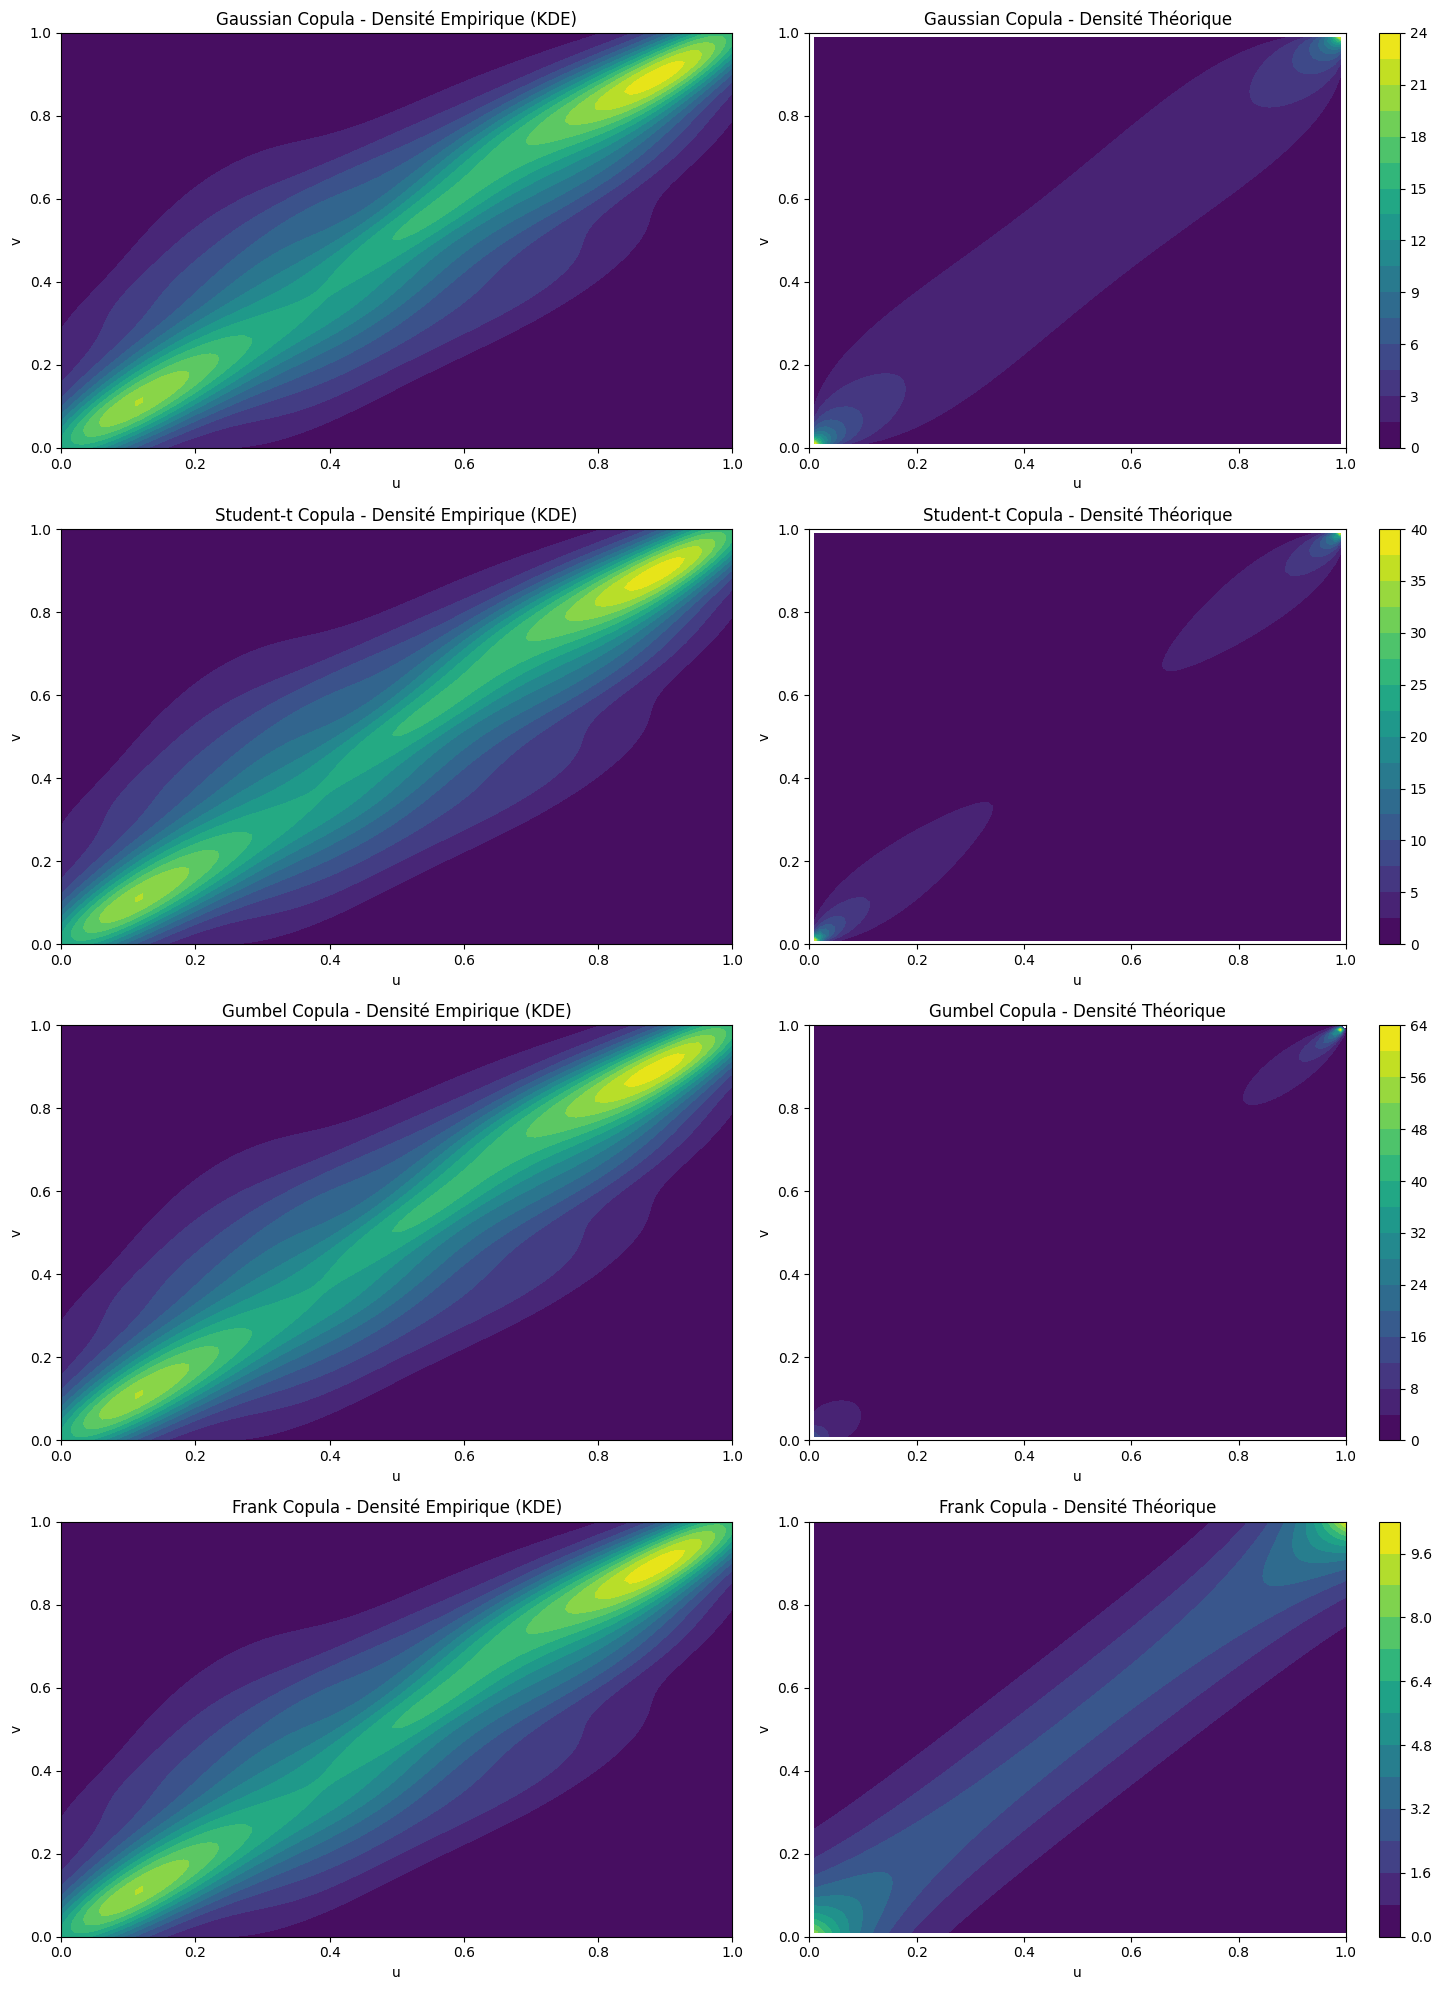

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copulae import GaussianCopula, StudentCopula
from copulae.archimedean import GumbelCopula, FrankCopula

# Configuration
grid_size = 100  # Résolution de la grille
contour_levels = 15  # Nombre de lignes de niveau

# Préparation des données
rank_data = data_returns.rank() / (len(data_returns) + 1)
u = rank_data.iloc[:, 0]
v = rank_data.iloc[:, 1]

# Création de la grille
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Estimation non paramétrique (KDE)
kernel = gaussian_kde(rank_data.values.T)
Z_kde = kernel(grid_points.T).reshape(X.shape)

# Préparation des copules
copulas = {
    "Gaussian": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2, df = 2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2)
}

# Création des graphiques
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for idx, (name, copula) in enumerate(copulas.items()):
    # Fit copula to data
    if name == "Student-t":
        copula.fit(rank_data.values, fix_df = True)
    else:
        copula.fit(rank_data.values)
    
    # Calcul de la densité théorique
    pdf = copula.pdf(grid_points).reshape(X.shape)
    
    # Lignes de niveau empiriques
    axs[idx, 0].contourf(X, Y, Z_kde, levels=contour_levels, cmap='viridis')
    axs[idx, 0].set_title(f'{name} Copula - Densité Empirique (KDE)')
    axs[idx, 0].set_xlabel('u')
    axs[idx, 0].set_ylabel('v')
    
    # Lignes de niveau théoriques
    cntr = axs[idx, 1].contourf(X, Y, pdf, levels=contour_levels, cmap='viridis')
    axs[idx, 1].set_title(f'{name} Copula - Densité Théorique')
    axs[idx, 1].set_xlabel('u')
    axs[idx, 1].set_ylabel('v')
    
    # Ajout de la colorbar
    fig.colorbar(cntr, ax=axs[idx, 1])

plt.tight_layout()
plt.show()

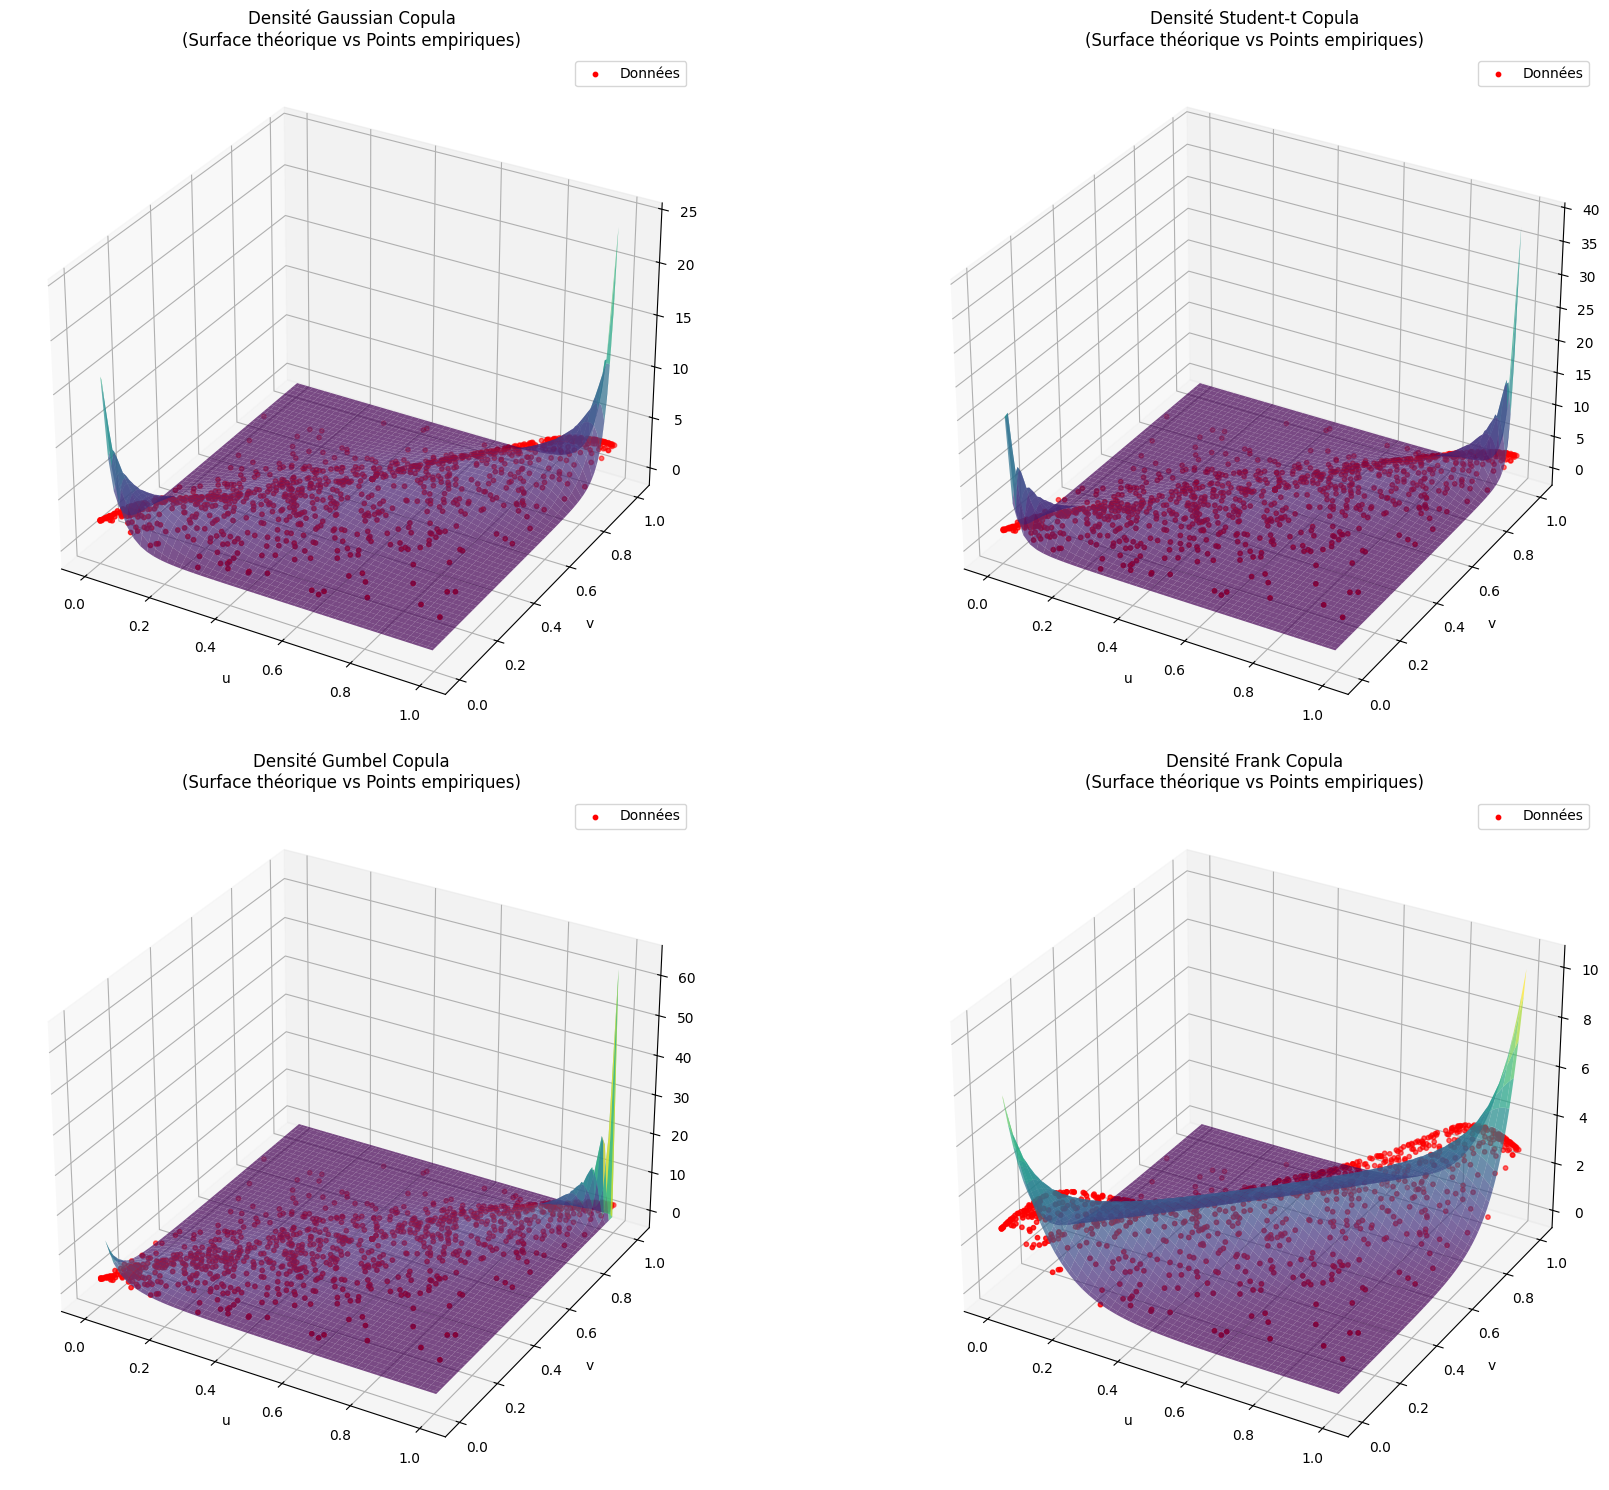

In [117]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

for idx, (name, copula) in enumerate(copulas.items(), 1):
    # Calcul de la densité théorique
    # Fit copula to data
    if name == "Student-t":
        copula.fit(rank_data.values, fix_df = True)
    else:
        copula.fit(rank_data.values)
        
    pdf = copula.pdf(grid_points).reshape(X.shape)
    
    # Graphique 3D
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    ax.plot_surface(X, Y, pdf, cmap='viridis', alpha=0.7)
    ax.scatter(u, v, kernel([u, v]), c='red', s=10, label='Données')
    ax.set_title(f'Densité {name} Copula\n(Surface théorique vs Points empiriques)')
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.legend()

plt.tight_layout()
plt.show()


=== Résultats du test d'adéquation (bootstrap paramétrique) ===
           Statistique  p-value
Copula                         
Gaussian      0.054595    0.000
Student-t     0.234763    0.232
Gumbel        0.034857    0.018
Frank         0.602916    0.002


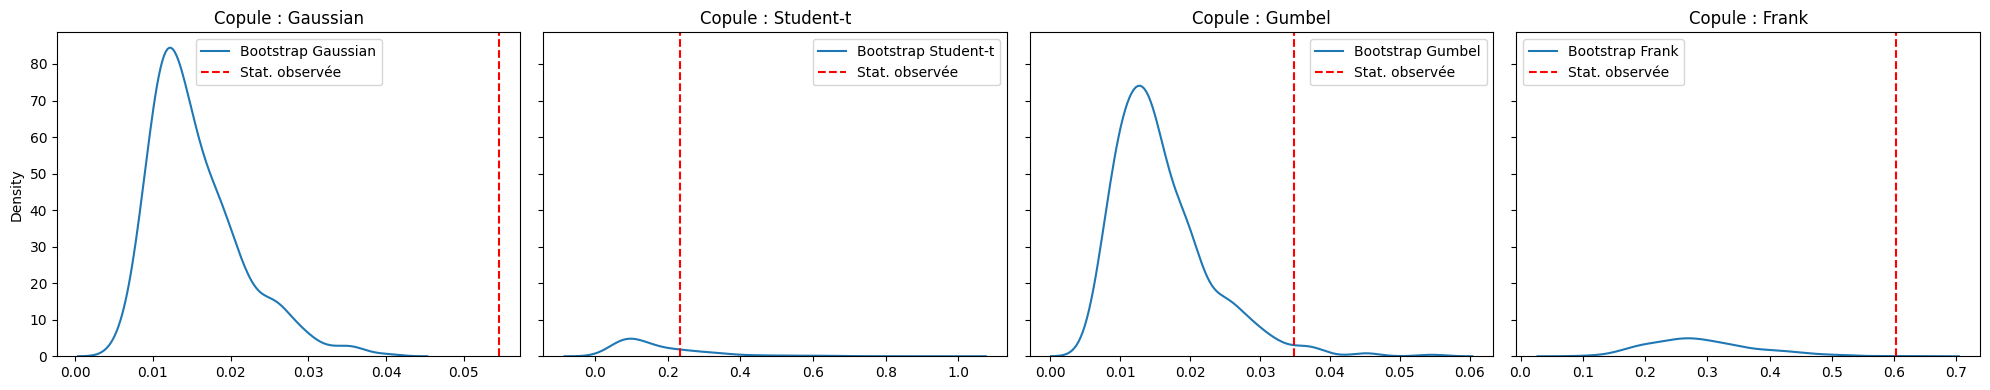

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata
from copulae import EmpiricalCopula, GaussianCopula, StudentCopula, FrankCopula, GumbelCopula

# --------------------------------------------------------------------
# 1) Préparation des données et pseudo-observations
# --------------------------------------------------------------------

np.random.seed(42)  # pour la reproductibilité

# Transformation en pseudo-observations dans [0,1]
rank_data = data_returns.rank(method='average') / (len(data_returns) + 1)
# Copule empirique à partir de ces pseudo-observations
emp_copula = EmpiricalCopula(rank_data.values)

# Dimension de la copule (nombre de colonnes)
d = rank_data.shape[1]

# --------------------------------------------------------------------
# 2) Définition des copules paramétriques
# --------------------------------------------------------------------
# Vous pouvez en ajouter/enlever selon vos besoins.
# Note: pour la Student, vous pouvez fixer le df ou l'estimer.

copula_models = {
    "Gaussian": GaussianCopula(dim=d),
    "Student-t": StudentCopula(dim=d, df = 2),  # on peut spécifier df=... si besoin
    "Gumbel":   GumbelCopula(dim=d),
    "Frank":    FrankCopula(dim=d)
}

# --------------------------------------------------------------------
# 3) Fonction pour calculer la statistique T_n
# --------------------------------------------------------------------
def test_statistic(copula_model, data):
    """
    Calcule T_n = ∑ [C_n(u_i) - C_theta(u_i)]²
    - data : array (n, d) des pseudo-observations (dans [0,1]^d).
    """
    # Copule empirique sur data
    emp_cop = EmpiricalCopula(data)
    # Valeurs C_theta(u_i) de la copule paramétrique
    
    # Spécial StudentCopula : Approximation Monte Carlo car cdf() n'est pas défini
    if isinstance(copula_model, StudentCopula):
        c_theoretical = copula_model.random(n=data.shape[0])  # Simulation Monte Carlo
        c_theoretical = np.mean(
            [np.all(c_theoretical <= u, axis=1) for u in data], axis=1
        )
    else:
        c_theoretical = copula_model.cdf(data)
    # Valeurs C_n(u_i) de la copule empirique
    c_empirical = emp_cop.cdf(data)
    # Somme des carrés des écarts
    return np.sum((c_theoretical - c_empirical) ** 2)

# --------------------------------------------------------------------
# 4) Bootstrap paramétrique pour estimer la p-value
# --------------------------------------------------------------------
def bootstrap_pvalue(copula_model, data, n_boot=200):
    """
    Effectue un bootstrap paramétrique :
      - on simule n_boot échantillons de même taille n
        depuis la copule ajustée,
      - on recalcule T_n sur chaque échantillon simulé,
      - la p-value est la proportion des T_n simulés >= T_n observé.
    """
    obs_stat = test_statistic(copula_model, data)
    n = data.shape[0]
    d = data.shape[1]

    boot_stats = []
    for _ in range(n_boot):
        # Simulation de données ~ Copule paramétrique
        sim_data = copula_model.random(n)
        # Transformation en pseudo-observations (rang/n+1),
        # pour rester cohérent avec la procédure sur les données réelles.
        sim_rank_data = np.column_stack([
            rankdata(sim_data[:, j]) / (n + 1)
            for j in range(d)
        ])
        # Statistique sur l'échantillon simulé
        stat = test_statistic(copula_model, sim_rank_data)
        boot_stats.append(stat)

    boot_stats = np.array(boot_stats)
    p_value = np.mean(boot_stats >= obs_stat)
    return p_value, obs_stat, boot_stats

# --------------------------------------------------------------------
# 5) Ajustement des copules + exécution du test pour chaque copule
# --------------------------------------------------------------------
results = []
bootstrap_results = {}

for name, model in copula_models.items():
    # Ajustement de la copule aux pseudo-observations
    # fix_df=False pour laisser le df s'estimer dans le cas Student
    if name == "Student-t":
        model.fit(rank_data.values, method='ml', fix_df=True)
    else:
        model.fit(rank_data.values, method='ml')

    # Calcul de la p-value par bootstrap
    pval, stat_obs, stats_boot = bootstrap_pvalue(model, rank_data.values, n_boot=500)

    results.append({
        "Copula":      name,
        "Statistique": stat_obs,
        "p-value":     pval
    })
    bootstrap_results[name] = {
        "obs":  stat_obs,
        "boot": stats_boot
    }

# --------------------------------------------------------------------
# 6) Résumé des résultats dans un DataFrame
# --------------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Résultats du test d'adéquation (bootstrap paramétrique) ===")
print(results_df.set_index("Copula"))

# --------------------------------------------------------------------
# 7) Visualisation des distributions bootstrap
# --------------------------------------------------------------------
# Pour chaque copule, on trace la distribution bootstrap de T_n
# et on indique la valeur observée.

fig, axes = plt.subplots(1, len(copula_models), figsize=(5 * len(copula_models), 4), sharey=True)

if len(copula_models) == 1:
    # Si on n'a qu'une copule, axes n'est pas un tableau de subplots
    axes = [axes]

for (name, res), ax in zip(bootstrap_results.items(), axes):
    boot_vals = res["boot"]
    obs_val   = res["obs"]
    sns.kdeplot(boot_vals, ax=ax, label=f"Bootstrap {name}")
    ax.axvline(obs_val, color='r', linestyle='--', label="Stat. observée")
    ax.set_title(f"Copule : {name}")
    ax.legend()

plt.tight_layout()
plt.show()

## Déterminer la CreditVaR à 99% du portefeuille en utilisant la méthode de Monte Carlo.

=== Estimation Copule t-Student Bivariée ===
Paramètre r estimé = 0.8496
Paramètre df estimé = 2.0000
Log-vraisemblance  = 719.7436
Convergence : True | Optimization terminated successfully.
